# March Machine Learning Mania 2017

## Season 分析



In [1]:
import csv
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

### 读取数据

In [2]:
# 读取RegularSeasonCompactResults
df_rscr = pd.read_csv('data/RegularSeasonCompactResults.csv')
df_rscr.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [216]:
# 读取RegularSeasonCompactResults
df_rsdr = pd.read_csv('data/RegularSeasonDetailedResults.csv')
df_rsdr.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [3]:
# 读取Teams
df_teams = pd.read_csv('data/Teams.csv')
df_teams.head()

,Team_Id,Team_Name
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


### 主客场胜率

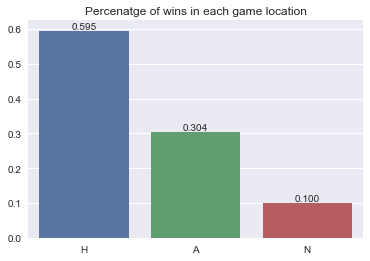

In [4]:
# 取 Wloc 列，并计数
se_wloc = df_rscr['Wloc'].value_counts()
# 绘制bar plot
ax = sns.barplot(list(se_wloc.axes[0]), se_wloc.values / se_wloc.sum())
# 写具体的值
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.005, '{:1.3f}'.format(height), ha="center") 
# 标题
ax.set_title('Percenatge of wins in each game location')
plt.show()

### 加时情况

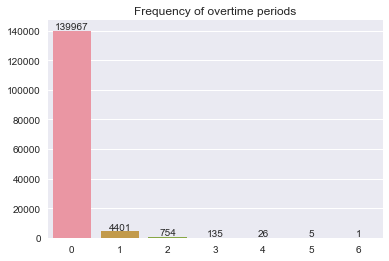

In [5]:
# 取 Numot 列，并计数
se_num_ot = df_rscr['Numot'].value_counts()
# 绘制bar plot
# plt.subplots(figsize=(12, 8))
ax = sns.barplot(list(se_num_ot.axes[0]), se_num_ot.values)
# 写具体的值
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 1000, '{:1.0f}'.format(height), ha="center") 
# 标题
ax.set_title('Frequency of overtime periods')
plt.show()

### Win percentage for all teams

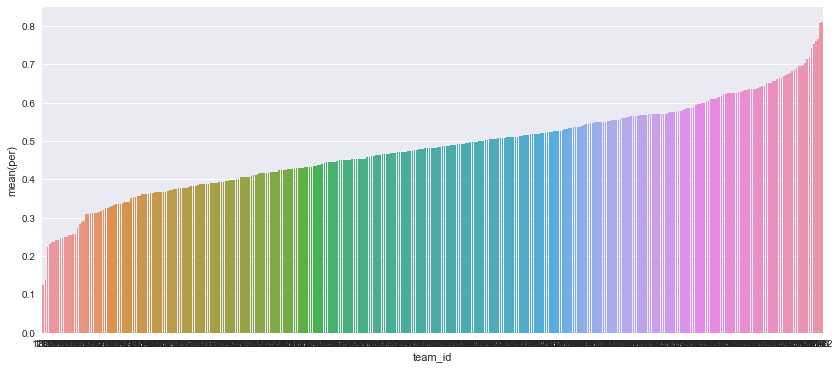

In [98]:
# 取 Wteam、Lteam 列，并计数
se_win_team = df_rscr['Wteam'].value_counts()
se_loss_team = df_rscr['Lteam'].value_counts()

teams_id = list(se_loss_team.axes[0])

# 计算胜率
df_win_per = pd.DataFrame(index=np.array(teams_id), columns=['team_id', 'win_num', 'loss_num', 'per', 'team_name'])
for team_id in teams_id:
    df_win_per.loc[team_id]['team_id'] = team_id
    df_win_per.loc[team_id]['win_num'] = se_win_team[team_id]
    df_win_per.loc[team_id]['loss_num'] = se_loss_team[team_id]
    df_win_per.loc[team_id]['per'] = se_win_team[team_id] / (se_win_team[team_id] + se_loss_team[team_id])
    df_win_per.loc[team_id]['team_name'] = df_teams.loc[df_teams['Team_Id'] == team_id].iloc[0]['Team_Name']

# 排序
df_win_per = df_win_per.sort_values('per')

# 绘图
plt.subplots(figsize=(14, 6))
sns.barplot(x='team_id', y='per', data=df_win_per, order=list(df_win_per['per'].axes[0]))
plt.show()

"What are the top 30 teams? "

In [99]:
# 胜率最好的30支球队
df_top_30 = df_win_per.tail(30)[::-1]

# 显示前15支 
df_top_30.head(15)

,team_id,win_num,loss_num,per,team_name
1242,1242,804,189,0.809668,Kansas
1181,1181,819,194,0.80849,Duke
1246,1246,765,234,0.765766,Kentucky
1112,1112,746,235,0.760449,Arizona
1314,1314,761,249,0.753465,North Carolina
1393,1393,738,255,0.743202,Syracuse
1211,1211,663,258,0.71987,Gonzaga
1462,1462,681,273,0.713836,Xavier
1424,1424,685,289,0.703285,UNLV
1272,1272,692,300,0.697581,Memphis


"What are the worst 30 teams? "

In [100]:
# 胜率最差的30支球队
df_worst_30 = df_win_per.head(30)

# 显示前15支 
df_worst_30.head(15)

,team_id,win_num,loss_num,per,team_name
1289,1289,6,42,0.125,Morris Brown
1327,1327,3,19,0.136364,Okla City
1118,1118,6,21,0.222222,Armstrong St
1146,1146,62,205,0.23221,Cent Arkansas
1101,1101,18,58,0.236842,Abilene Chr
1152,1152,205,660,0.236994,Chicago St
1255,1255,83,261,0.241279,Longwood
1445,1445,26,81,0.242991,W Salem St
1188,1188,51,156,0.246377,Edwardsville
1341,1341,212,645,0.247375,Prairie View


### Average points scored for each team

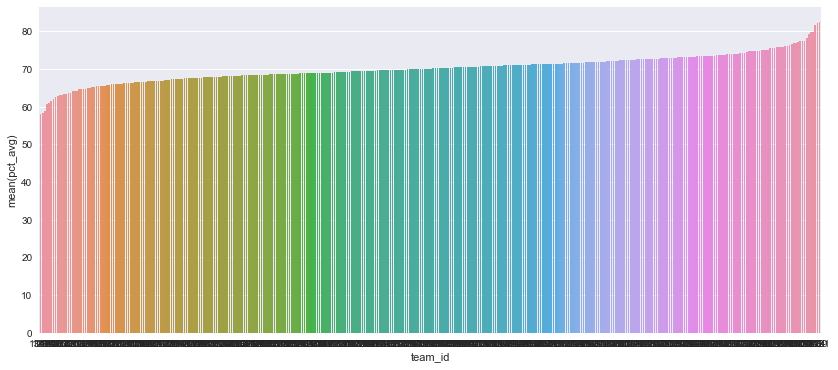

In [141]:
# 获取每个球队胜利的平均分、总分、场次
grp_win = df_rscr.groupby('Wteam')['Wscore']
win_score_mean = grp_win.mean()
win_score_sum = grp_win.sum()
win_count = grp_win.count()

# 获取每个球队失败的平均分、总分、场次
grp_loss = df_rscr.groupby('Lteam')['Lscore']
loss_score_mean = grp_loss.mean()
loss_score_sum = grp_loss.sum()
loss_count = grp_loss.count()

# 计算所以场次的平均分
df_points = pd.DataFrame(
    index=np.array(teams_id),
    columns=['team_id', 'team_name', 'pct_avg', 'pct_count', 'win_avg', 'win_count', 'loss_avg', 'loss_count'])
for team_id in teams_id:
    df_points.loc[team_id]['team_id'] = team_id
    df_points.loc[team_id]['team_name'] = df_teams.loc[df_teams['Team_Id'] == team_id].iloc[0]['Team_Name']
    df_points.loc[team_id]['win_avg'] = win_score_mean.loc[team_id]
    df_points.loc[team_id]['win_count'] = win_count.loc[team_id]
    df_points.loc[team_id]['loss_avg'] = loss_score_mean.loc[team_id]
    df_points.loc[team_id]['loss_count'] = loss_count.loc[team_id]
    df_points.loc[team_id]['pct_count'] = win_count.loc[team_id] + loss_count.loc[team_id]
    df_points.loc[team_id]['pct_avg'] = (loss_score_sum.loc[team_id] + win_score_sum.loc[team_id]) / (win_count.loc[team_id] + loss_count.loc[team_id])

# 排序
df_points = df_points.sort_values('pct_avg')

# 绘图
plt.subplots(figsize=(14, 6))
sns.barplot(x='team_id', y='pct_avg', data=df_points, order=list(df_points['pct_avg'].axes[0]))
plt.show()

"What are the top 30 teams? "

In [142]:
df_points_top_30 = df_points[::-1].head(30)

df_points_top_30.head(15)

,team_id,team_name,pct_avg,pct_count,win_avg,win_count,loss_avg,loss_count
1181,1181,Duke,82.3939,1013,84.6252,819,72.9742,194
1109,1109,Alliant Intl,82.2426,169,90.4286,42,79.5354,127
1314,1314,North Carolina,81.6208,1010,84.8988,761,71.6024,249
1242,1242,Kansas,79.8731,993,82.5261,804,68.5873,189
1328,1328,Oklahoma,79.7603,968,84.636,673,68.6373,295
1112,1112,Arizona,79.3058,981,82.2198,746,70.0553,235
1116,1116,Arkansas,78.2541,980,84.5216,625,67.2197,355
1246,1246,Kentucky,77.4014,999,80.0706,765,68.6752,234
1424,1424,UNLV,77.3398,974,81.4102,685,67.692,289
1400,1400,Texas,77.2709,982,80.8742,652,70.1515,330


"What are the worst 30 teams? "

In [143]:
df_points_worst_30 = df_points.head(30)

df_points_worst_30.head(15)

,team_id,team_name,pct_avg,pct_count,win_avg,win_count,loss_avg,loss_count
1366,1366,Savannah St,57.8958,384,64.3167,120,54.9773,264
1289,1289,Morris Brown,58.3542,48,71.5,6,56.4762,42
1445,1445,W Salem St,58.7383,107,69.2308,26,55.3704,81
1115,1115,Ark Pine Bluff,60.6308,520,68.4966,147,57.5308,373
1342,1342,Presbyterian,60.9731,260,69.3881,67,58.0518,193
1343,1343,Princeton,61.5421,832,66.0095,527,53.823,305
1127,1127,Binghamton,61.9321,442,69.0637,157,58.0035,285
1446,1446,W Texas A&M,62.4792,48,68.2857,14,60.0882,34
1162,1162,Columbia,62.9218,831,69.8949,314,58.6867,517
1415,1415,UC Riverside,62.9785,418,70.7348,132,59.3986,286


### How does the number of points scored correlate to the game result?

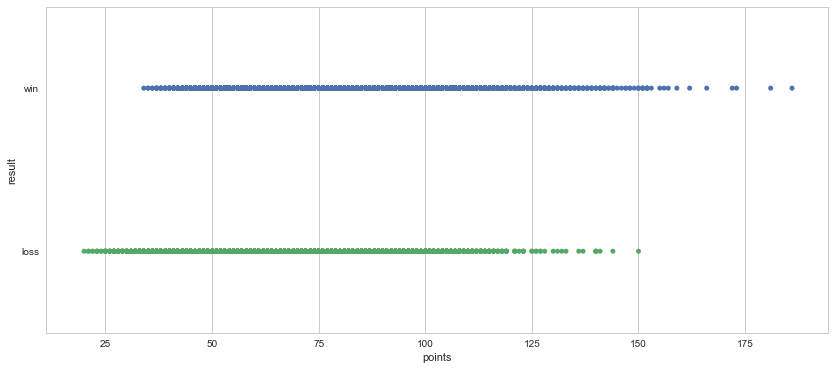

In [218]:
win_points = list(df_rscr['Wscore'].values)
loss_points = list(df_rscr['Lscore'].values)

# 构建 得分-结果 关系
df_points_result = pd.DataFrame(index=np.array(range(len(win_points) + len(loss_points))), columns=['points', 'result'])
df_points_result['points'] = win_points + loss_points
df_points_result['result'] = ['win'] * len(win_points) + ['loss'] * len(loss_points)
df_points_result

# 绘图
plt.subplots(figsize=(14, 6))
ax = sns.stripplot(x="points", y="result", data=df_points_result)
plt.show()

### Win probability across features

In [277]:
ss = df_points_result.groupby(['points', 'result'])['result'].agg({'per': 'count'})

ss = ss.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

ss = ss[ss.index.map(lambda x: x[1] == 'win')]
print(ss)

#sns.stripplot(x="points", y="per", data=ss)

                      per
points result            
34     win       1.492537
35     win       1.818182
36     win       1.250000
37     win       2.450980
38     win       2.325581
39     win       1.823708
40     win       2.857143
41     win       3.275530
42     win       4.147465
43     win       4.851752
44     win       4.794521
45     win       7.192982
46     win       6.331593
47     win       7.233273
48     win       8.315565
49     win       8.665208
50     win      10.818043
51     win      12.452959
52     win      12.916423
53     win      15.103756
54     win      16.469222
55     win      18.111918
56     win      19.890957
57     win      22.505759
58     win      23.703228
59     win      26.372443
60     win      28.146552
61     win      29.585402
62     win      31.404211
63     win      34.633309
...                   ...
134    win     100.000000
135    win     100.000000
136    win      85.714286
137    win      80.000000
138    win     100.000000
139    win  